<a href="https://colab.research.google.com/github/envirodatascience/final-project-wildfire/blob/main/Graphs_over_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wildfires in the United States

This project examines the landscape of wildfires in the US from 1984-2024. We aim to answer the following questions using data from the US Geological Service that monitors trends in burn severity over this time period:

1) How has wildfire frequency changed over time in the US?

2) How has wildfire severity changed over time in the US?

3) Is prescribed burning an effective policy for mitigating fires?

In [43]:
# import packages
import pandas as pd
import numpy as np

import geopandas as gpd
from plotnine import *
import plotnine
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.api as sm

# Upload Data
We are pulling data from The Monitoring Trends in Burn Severity (MTBS) Program provided by the USGS and USDA Forest Service

The data provides info regarding all currently inventoried fires occurring between calendar year 1984 and 2024 for CONUS, Alaska, Hawaii, and Puerto Rico.

In [2]:
# mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#upload fire severity data
! unzip /content/drive/MyDrive/mtbs_perims_DD.zip #unpacks zipped folder


Archive:  /content/drive/MyDrive/mtbs_perims_DD.zip
  inflating: mtbs_perims_DD.cpg      
  inflating: mtbs_perims_DD.dbf      
  inflating: mtbs_perims_DD.prj      
  inflating: mtbs_perims_DD.sbn      
  inflating: mtbs_perims_DD.sbx      
  inflating: mtbs_perims_DD.shp      
  inflating: mtbs_perims_DD.shp.xml  
  inflating: mtbs_perims_DD.shx      
  inflating: mtbs_perims_DD_ISO_metadata.xml  
  inflating: mtbs_perims_DD_metadata.xml  


In [4]:
shape = "mtbs_perims_DD.shp"
df = gpd.read_file(shape) #reads in shape file

#Orienting and Data Cleaning

In [5]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 30331 entries, 0 to 30330
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Event_ID    30331 non-null  object        
 1   irwinID     6264 non-null   object        
 2   Incid_Name  30331 non-null  object        
 3   Incid_Type  30331 non-null  object        
 4   Map_ID      30331 non-null  int64         
 5   Map_Prog    30331 non-null  object        
 6   Asmnt_Type  30331 non-null  object        
 7   BurnBndAc   30331 non-null  int64         
 8   BurnBndLat  30331 non-null  object        
 9   BurnBndLon  30331 non-null  object        
 10  Ig_Date     30331 non-null  datetime64[ms]
 11  Pre_ID      22056 non-null  object        
 12  Post_ID     30331 non-null  object        
 13  Perim_ID    2878 non-null   object        
 14  dNBR_offst  30331 non-null  int64         
 15  dNBR_stdDv  30331 non-null  int64         
 16  NoData_T    30

In [6]:
df.head()

,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,BurnBndLon,...,Perim_ID,dNBR_offst,dNBR_stdDv,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,geometry
0,AK6260315742119850801,None,CAMELBACK,Wildfire,4737,MTBS,Extended,4780,62.603,-157.421,...,None,27,-9999,-970,-150,130,334,585,None,"POLYGON ((-157.44988 62.62182, -157.44895 62.6..."
1,AK6256215664519850720,None,SUGARLOAF,Wildfire,4738,MTBS,Extended,5489,62.562,-156.645,...,None,3,-9999,-970,-150,70,320,600,None,"POLYGON ((-156.69736 62.57441, -156.70027 62.5..."
2,AK6547615382919850801,None,TAL NW 44,Wildfire,4739,MTBS,Extended,1491,65.476,-153.829,...,None,14,-9999,-970,-150,50,275,530,None,"POLYGON ((-153.84454 65.46265, -153.84574 65.4..."
3,AK6521015526519850803,None,GAL NE 48,Wildfire,4740,MTBS,Extended,1298,65.210,-155.265,...,None,14,-9999,-970,-150,100,321,580,None,"POLYGON ((-155.27031 65.22507, -155.26915 65.2..."
4,AZ3178311066219850302,None,UNNAMED,Wildfire,4741,MTBS,Initial,1326,31.783,-110.662,...,None,-10,-9999,-970,-150,25,152,320,Hard to delineate fire perimeter,"POLYGON ((-110.6733 31.75345, -110.67378 31.75..."


In [7]:
#create state column from event ID
df['State'] = df['Event_ID'].str[:2]
df['State'].unique()

array(['AK', 'AZ', 'SD', 'CA', 'WA', 'OR', 'FL', 'NV', 'CO', 'ID', 'NM',
       'UT', 'WY', 'MT', 'NE', 'AL', 'GA', 'NC', 'SC', 'LA', 'ME', 'MI',
       'MN', 'NJ', 'VA', 'NY', 'AR', 'DE', 'MS', 'ND', 'TX', 'KY', 'TN',
       'WI', 'MO', 'WV', 'MD', 'KS', 'OK', 'IN', 'IA', 'HI', 'OH', 'MA',
       'PA', 'PR', 'IL'], dtype=object)

In [8]:
df_state = df.pop('State')
df.insert(0,'State',df_state)
df.head()

,State,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,...,Perim_ID,dNBR_offst,dNBR_stdDv,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,geometry
0,AK,AK6260315742119850801,None,CAMELBACK,Wildfire,4737,MTBS,Extended,4780,62.603,...,None,27,-9999,-970,-150,130,334,585,None,"POLYGON ((-157.44988 62.62182, -157.44895 62.6..."
1,AK,AK6256215664519850720,None,SUGARLOAF,Wildfire,4738,MTBS,Extended,5489,62.562,...,None,3,-9999,-970,-150,70,320,600,None,"POLYGON ((-156.69736 62.57441, -156.70027 62.5..."
2,AK,AK6547615382919850801,None,TAL NW 44,Wildfire,4739,MTBS,Extended,1491,65.476,...,None,14,-9999,-970,-150,50,275,530,None,"POLYGON ((-153.84454 65.46265, -153.84574 65.4..."
3,AK,AK6521015526519850803,None,GAL NE 48,Wildfire,4740,MTBS,Extended,1298,65.210,...,None,14,-9999,-970,-150,100,321,580,None,"POLYGON ((-155.27031 65.22507, -155.26915 65.2..."
4,AZ,AZ3178311066219850302,None,UNNAMED,Wildfire,4741,MTBS,Initial,1326,31.783,...,None,-10,-9999,-970,-150,25,152,320,Hard to delineate fire perimeter,"POLYGON ((-110.6733 31.75345, -110.67378 31.75..."


In [9]:
df['Incid_Type'].unique()

array(['Wildfire', 'Prescribed Fire', 'Unknown', 'Wildland Fire Use'],
      dtype=object)

In [10]:
# filter out columns
df_columns = df.drop(columns=['Event_ID', 'irwinID', 'Map_ID', 'Map_Prog', 'Asmnt_Type', 'Pre_ID', 'Post_ID', 'Perim_ID', 'Comment', 'dNBR_stdDv'])
df_columns.head()

,State,Incid_Name,Incid_Type,BurnBndAc,BurnBndLat,BurnBndLon,Ig_Date,dNBR_offst,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,geometry
0,AK,CAMELBACK,Wildfire,4780,62.603,-157.421,1985-08-01,27,-970,-150,130,334,585,"POLYGON ((-157.44988 62.62182, -157.44895 62.6..."
1,AK,SUGARLOAF,Wildfire,5489,62.562,-156.645,1985-07-20,3,-970,-150,70,320,600,"POLYGON ((-156.69736 62.57441, -156.70027 62.5..."
2,AK,TAL NW 44,Wildfire,1491,65.476,-153.829,1985-08-01,14,-970,-150,50,275,530,"POLYGON ((-153.84454 65.46265, -153.84574 65.4..."
3,AK,GAL NE 48,Wildfire,1298,65.210,-155.265,1985-08-03,14,-970,-150,100,321,580,"POLYGON ((-155.27031 65.22507, -155.26915 65.2..."
4,AZ,UNNAMED,Wildfire,1326,31.783,-110.662,1985-03-02,-10,-970,-150,25,152,320,"POLYGON ((-110.6733 31.75345, -110.67378 31.75..."


In [11]:
#check for missing/null values
df_columns['NoData_T'].unique()


array([ -970,  9999,  -870, -1070, -1000,  -900, -1020,  -950,  -920,
           0])

In [12]:
# df_columns['NoData_T'].value_counts()

#Wildfire Dynamics over Time

We want to investigate how fire size, severity, and frequency change over time.

In [13]:
# filter for wildfires
df_wildfires = df_columns[df_columns['Incid_Type'] == 'Wildfire']

In [62]:
# bucket by year
df_wildfires['Ig_Date'] = pd.to_datetime(df_wildfires['Ig_Date'])
df_wildfires['Year'] = df_wildfires['Ig_Date'].dt.year
df_wildfires_years = df_wildfires.pivot_table(index = 'Year', values = 'Incid_Type', aggfunc = 'count')
df_wildfires_years = df_wildfires_years.rename(columns = {'Incid_Type': 'Wildfires'})
df_wildfires_years = df_wildfires_years.reset_index()
df_wildfires_years.head()

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Year,Wildfires
0,1984,188
1,1985,417
2,1986,281
3,1987,413
4,1988,400


Wildfire Frequency over Time

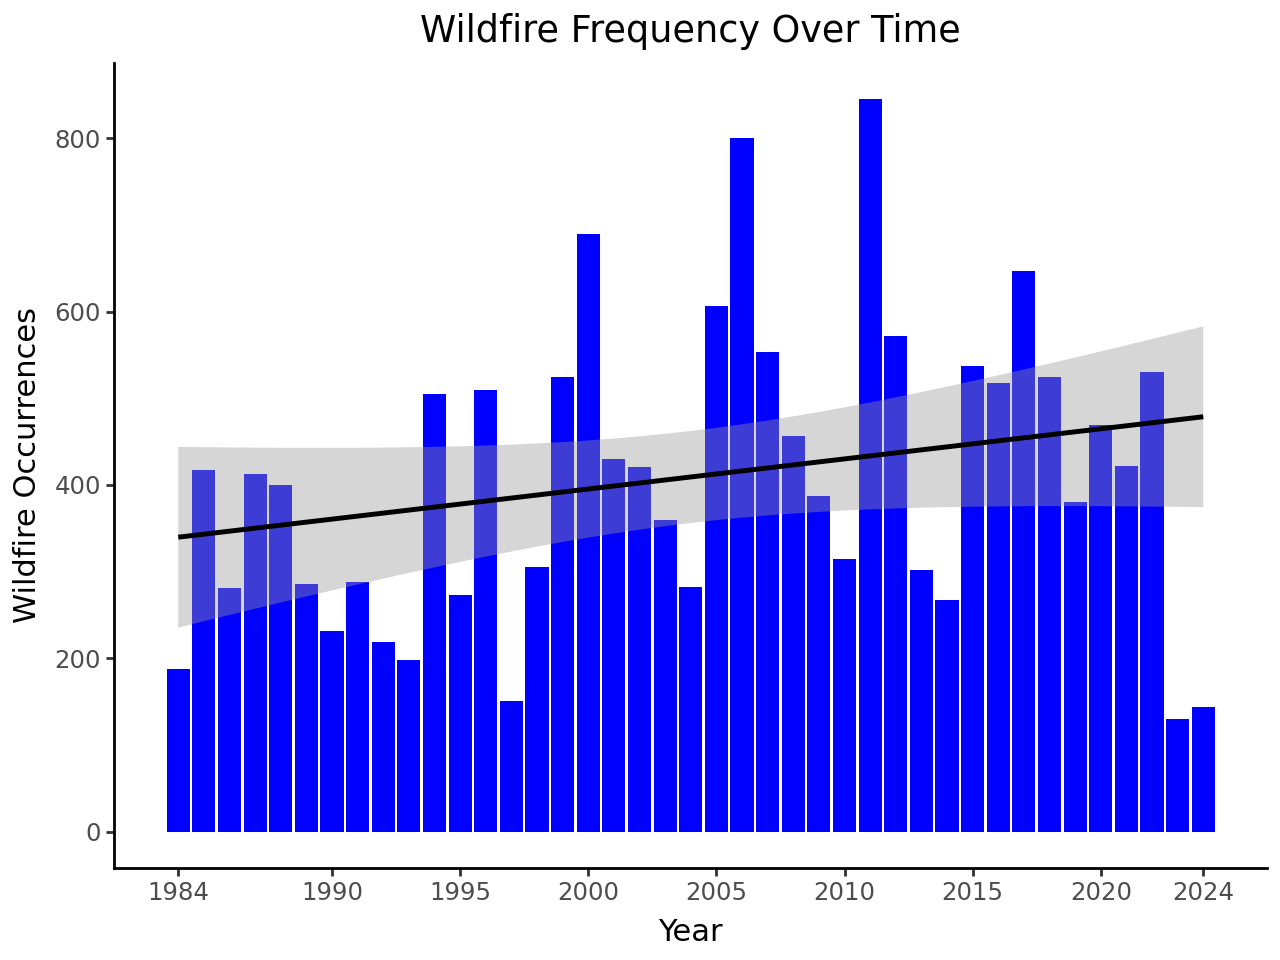

In [15]:
# fire frequency over time
(
    ggplot(df_wildfires_years, aes(x = 'Year', y='Incid_Type'))
       + geom_bar(stat = 'identity', fill = 'blue')
       + geom_smooth(method='lm')
       + xlab("Year")
       + ylab("Wildfire Occurrences")
       + ggtitle("Wildfire Frequency Over Time")
       + scale_x_continuous(breaks = [1984, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024])
       + theme_classic()

)

In [16]:
# year of highest fire frequency
df_wildfires_years.sort_values(by = 'Incid_Type', ascending = False).head(1)

,Year,Incid_Type
27,2011,845


The graph shows that the frequency of fires has trended upward over time, with a peak in 2011.

Wildfire Size over Time

In [17]:
# aggregate burned acres per year
df_wildfires_acres = df_wildfires.pivot_table(index = 'Year', values = 'BurnBndAc', aggfunc = 'sum')
df_wildfires_acres['BurnBndAc'] = df_wildfires_acres['BurnBndAc'].astype(int)
df_wildfires_acres['BurnBndAc'] = df_wildfires_acres['BurnBndAc'] / 1000000
df_wildfires_acres = df_wildfires_acres.reset_index()
df_wildfires_acres.head()

,Year,BurnBndAc
0,1984,1.239015
1,1985,3.198033
2,1986,1.824537
3,1987,2.290434
4,1988,4.627236


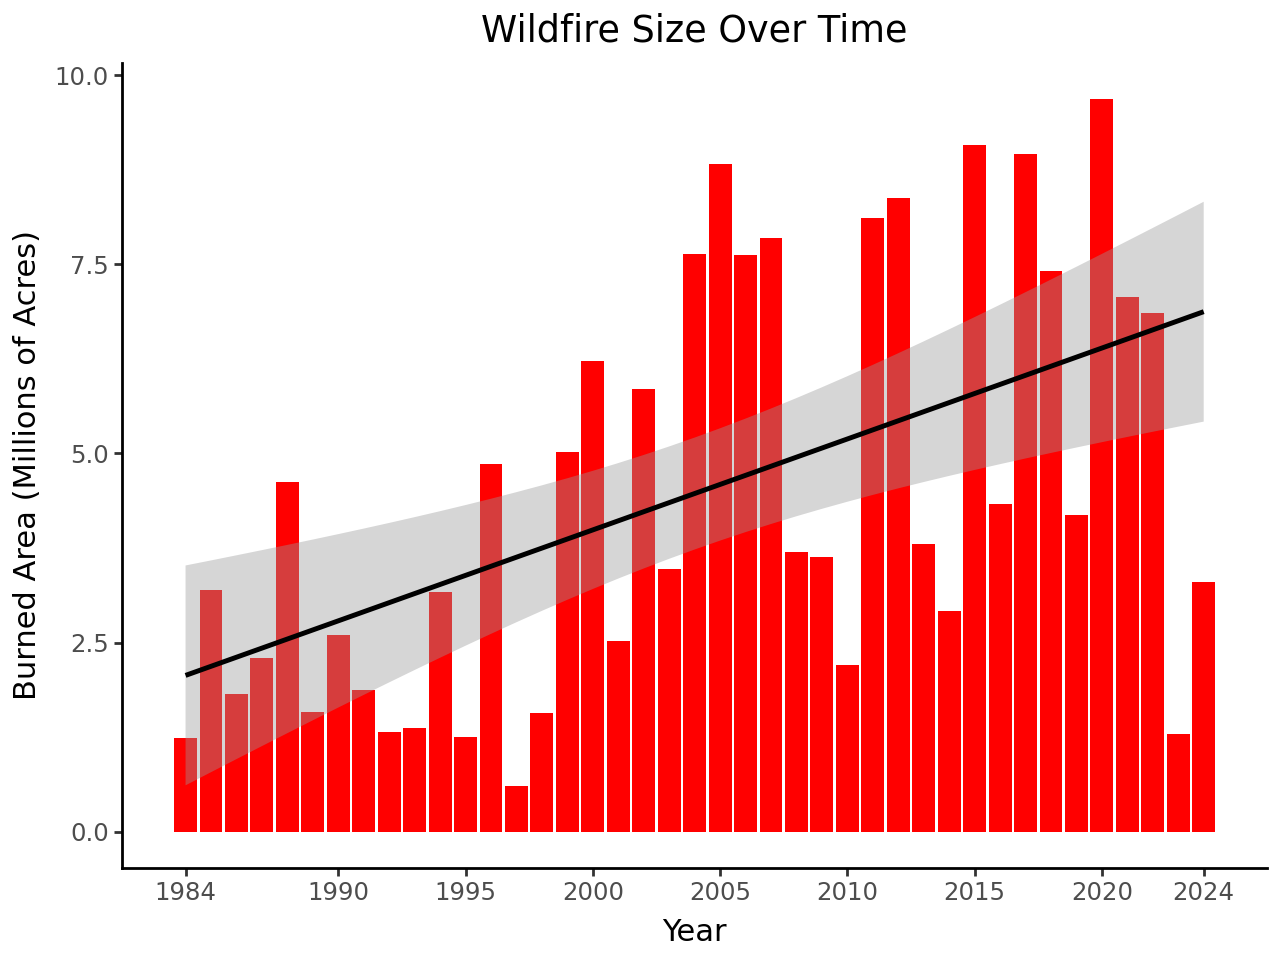

In [18]:
# fire size over time
(
    ggplot(df_wildfires_acres, aes(x = 'Year', y='BurnBndAc'))
       + geom_bar(stat = 'identity', fill = 'red')
       + geom_smooth(method='lm')
       + xlab("Year")
       + ylab("Burned Area (Millions of Acres)")
       + ggtitle("Wildfire Size Over Time")
       + scale_x_continuous(breaks = [1984, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024])
       + scale_y_continuous()
       + theme_classic()
)

In [19]:
# check year of worst fires by acres burned
df_wildfires_acres.sort_values(by = 'BurnBndAc', ascending = False).head(1)

,Year,BurnBndAc
36,2020,9.68503


As the graph shows, the acres burned by wildfires has increased over time, with 2020 as the worst year for land affected by wildfires.  

# Wildfire Severity over Time

We measure wildfire severity by dNBR.

In [20]:
#check dNBR details
df_wildfires['dNBR_offst'].describe()

,dNBR_offst
count,16775.000000
mean,-1596.424799
std,3669.895293
min,-9999.000000
25%,-38.000000
50%,-2.000000
75%,23.000000
max,306.000000


In [21]:
# aggregate dNBR per year
df_wildfires_dNBR = df_wildfires.pivot_table(index = 'Year', values = 'dNBR_offst', aggfunc = 'mean')
df_wildfires_dNBR = df_wildfires_dNBR.reset_index()
df_wildfires_dNBR.head()

,Year,dNBR_offst
0,1984,-4942.053191
1,1985,-1907.498801
2,1986,-1488.284698
3,1987,-3081.021792
4,1988,-2092.267500


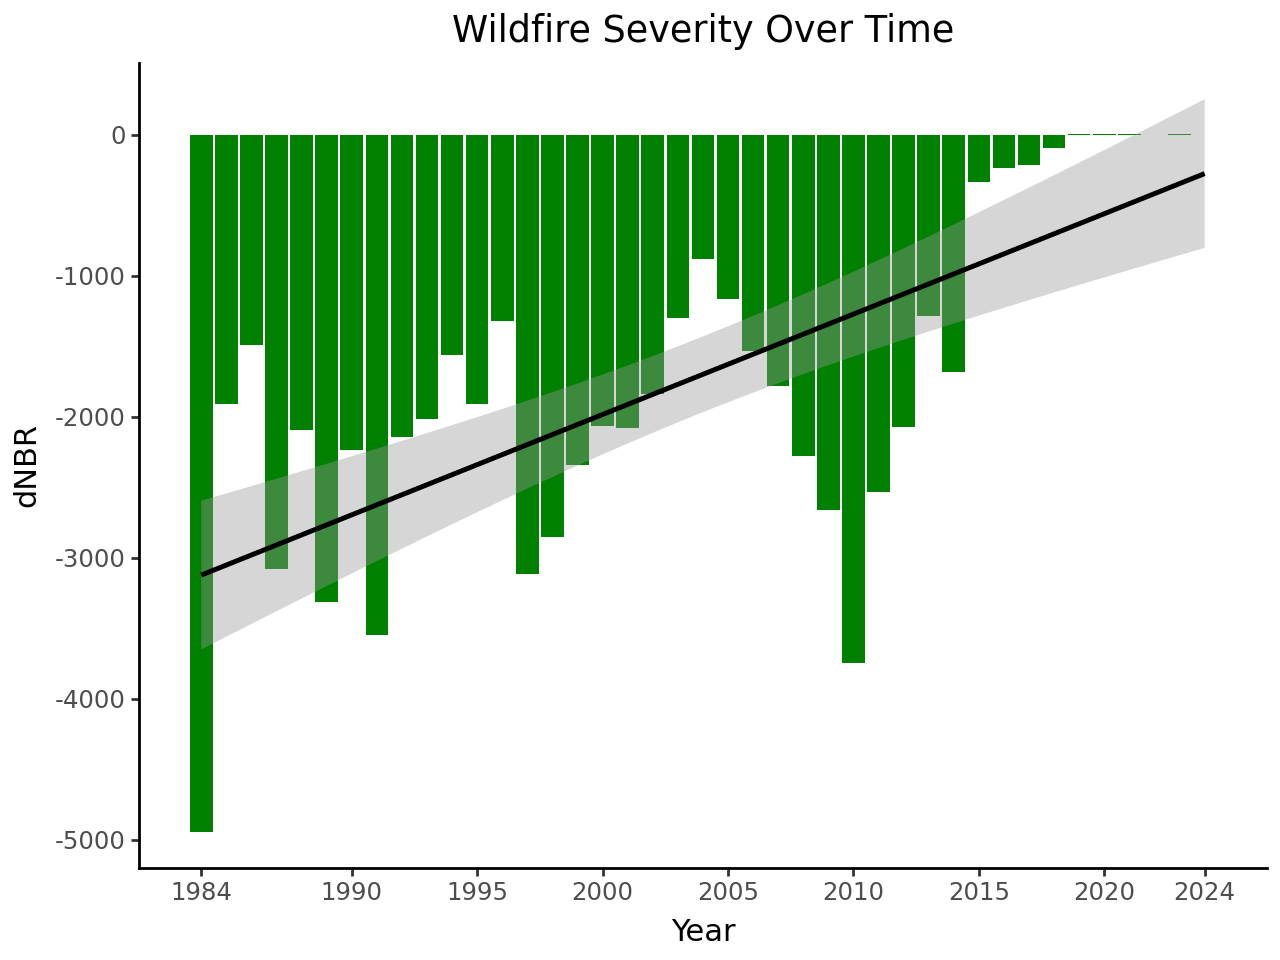

In [22]:
# dNBR over time
(
    ggplot(df_wildfires_dNBR, aes(x = 'Year', y='dNBR_offst'))
    + geom_bar(stat = 'identity', fill = 'green')
    + geom_smooth(method='lm')
    + theme_classic()
    + xlab("Year")
    + ylab("dNBR")
    + ggtitle("Wildfire Severity Over Time")
    + scale_x_continuous(breaks = [1984, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024])
)

#Prescribed Burns vs Wildfires over Time

How does the occurrence of prescribed burns relate to wildfires?

In [23]:
df_columns['Incid_Type'].unique()

array(['Wildfire', 'Prescribed Fire', 'Unknown', 'Wildland Fire Use'],
      dtype=object)

In [24]:
# filter for prescribed burns
df_prescribed = df_columns[df_columns['Incid_Type'] == 'Prescribed Fire']
df_prescribed.head()

,State,Incid_Name,Incid_Type,BurnBndAc,BurnBndLat,BurnBndLon,Ig_Date,dNBR_offst,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,geometry
192,CA,BEAR MTN. 4,Prescribed Fire,1473,38.156,-120.739,1985-09-17,18,-970,-150,100,264,475,"POLYGON ((-120.76035 38.17445, -120.7603 38.17..."
193,CA,BLUE MTN. WEST,Prescribed Fire,4627,40.564,-121.969,1985-08-27,-11,-970,-150,40,9999,9999,"POLYGON ((-121.9987 40.55225, -121.99769 40.55..."
360,NJ,UNNAMED,Prescribed Fire,761,39.631,-74.410,1985-03-08,-9999,9999,9999,250,20,-9999,"POLYGON ((-74.40977 39.6343, -74.41001 39.6341..."
361,NJ,UNNAMED,Prescribed Fire,768,39.914,-74.467,1985-03-01,-9999,9999,9999,275,-9999,-9999,"MULTIPOLYGON (((-74.44289 39.91073, -74.44268 ..."
362,NJ,UNNAMED,Prescribed Fire,1685,39.774,-74.784,1985-03-01,-9999,9999,9999,225,-9999,-9999,"POLYGON ((-74.79944 39.77788, -74.80007 39.778..."


In [61]:
# prescribed fires by year

df_prescribed['Ig_Date'] = pd.to_datetime(df_prescribed['Ig_Date'])
df_prescribed['Year'] = df_prescribed['Ig_Date'].dt.year
df_prescribed_years = df_prescribed.pivot_table(index = 'Year', values = 'Incid_Type', aggfunc = 'count')
df_prescribed_years = df_prescribed_years.rename(columns = {'Incid_Type': 'Prescribed Fires'})
df_prescribed_years = df_prescribed_years.reset_index()
df_prescribed_years.head()


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Year,Prescribed Fires
0,1984,11
1,1985,8
2,1986,19
3,1987,7
4,1988,12


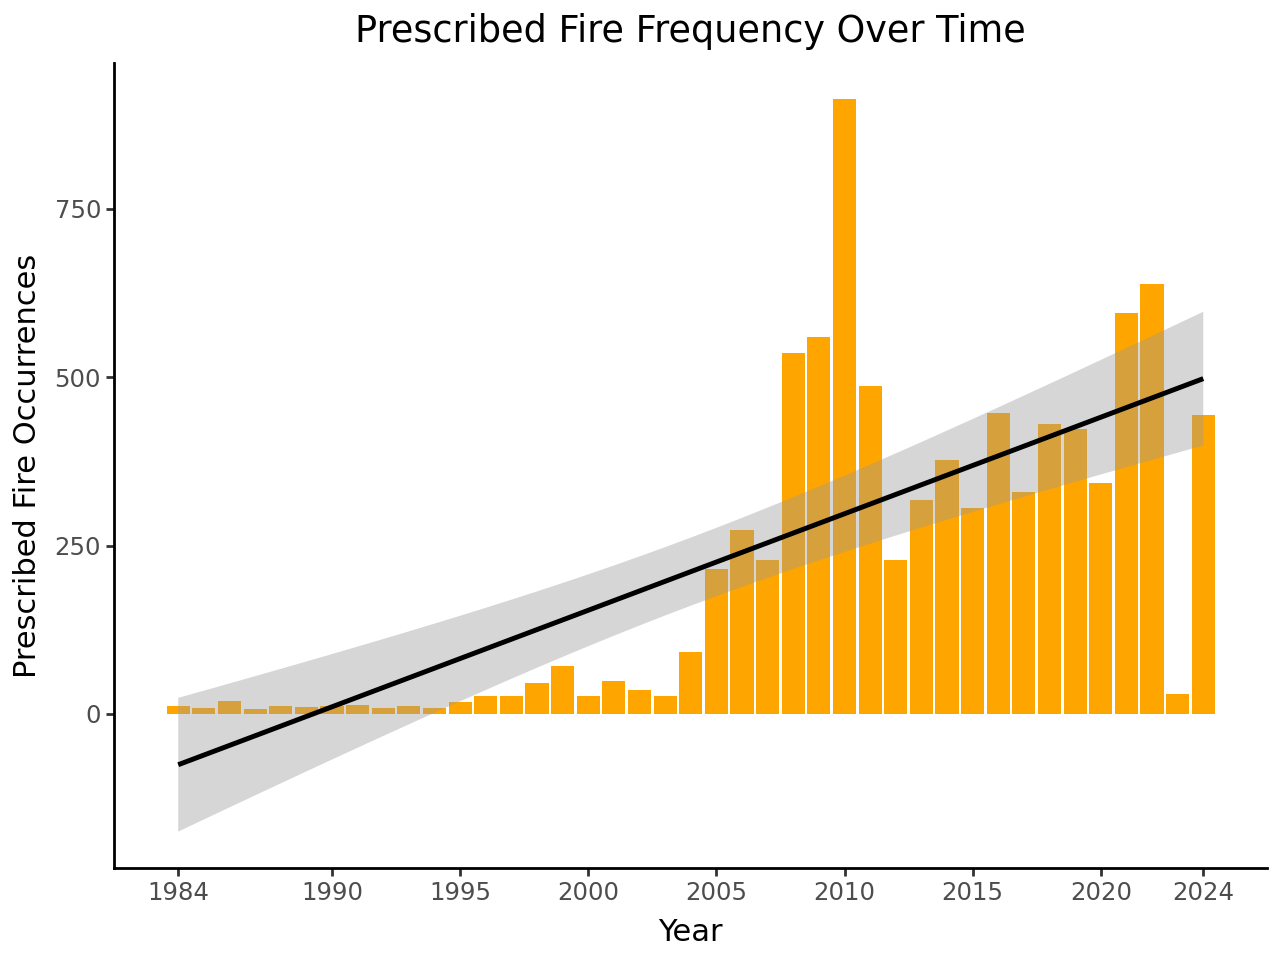

In [26]:
# prescribed fire count over time
(
    ggplot(df_prescribed_years, aes(x = 'Year', y='Incid_Type'))
       + geom_bar(stat = 'identity', fill = 'orange')
       + geom_smooth(method='lm')
       + xlab("Year")
       + ylab("Prescribed Fire Occurrences")
       + ggtitle("Prescribed Fire Frequency Over Time")
       + scale_x_continuous(breaks = [1984, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024])
       + theme_classic()
)

Now we want to look at how prescribed and wildfire trends relate over time.

In [84]:
#merge frequency dataframes
df_freq_merged = pd.merge(df_wildfires_years, df_prescribed_years, on = 'Year')
df_freq_merged.head()

,Year,Wildfires,Prescribed Fires
0,1984,188,11
1,1985,417,8
2,1986,281,19
3,1987,413,7
4,1988,400,12


In [85]:
# melt frequency
df_freq_melted = pd.melt(df_freq_merged, id_vars=['Year'], value_vars=['Wildfires', 'Prescribed Fires'], var_name='series', value_name='value')
df_freq_melted.head()

,Year,series,value
0,1984,Wildfires,188
1,1985,Wildfires,417
2,1986,Wildfires,281
3,1987,Wildfires,413
4,1988,Wildfires,400


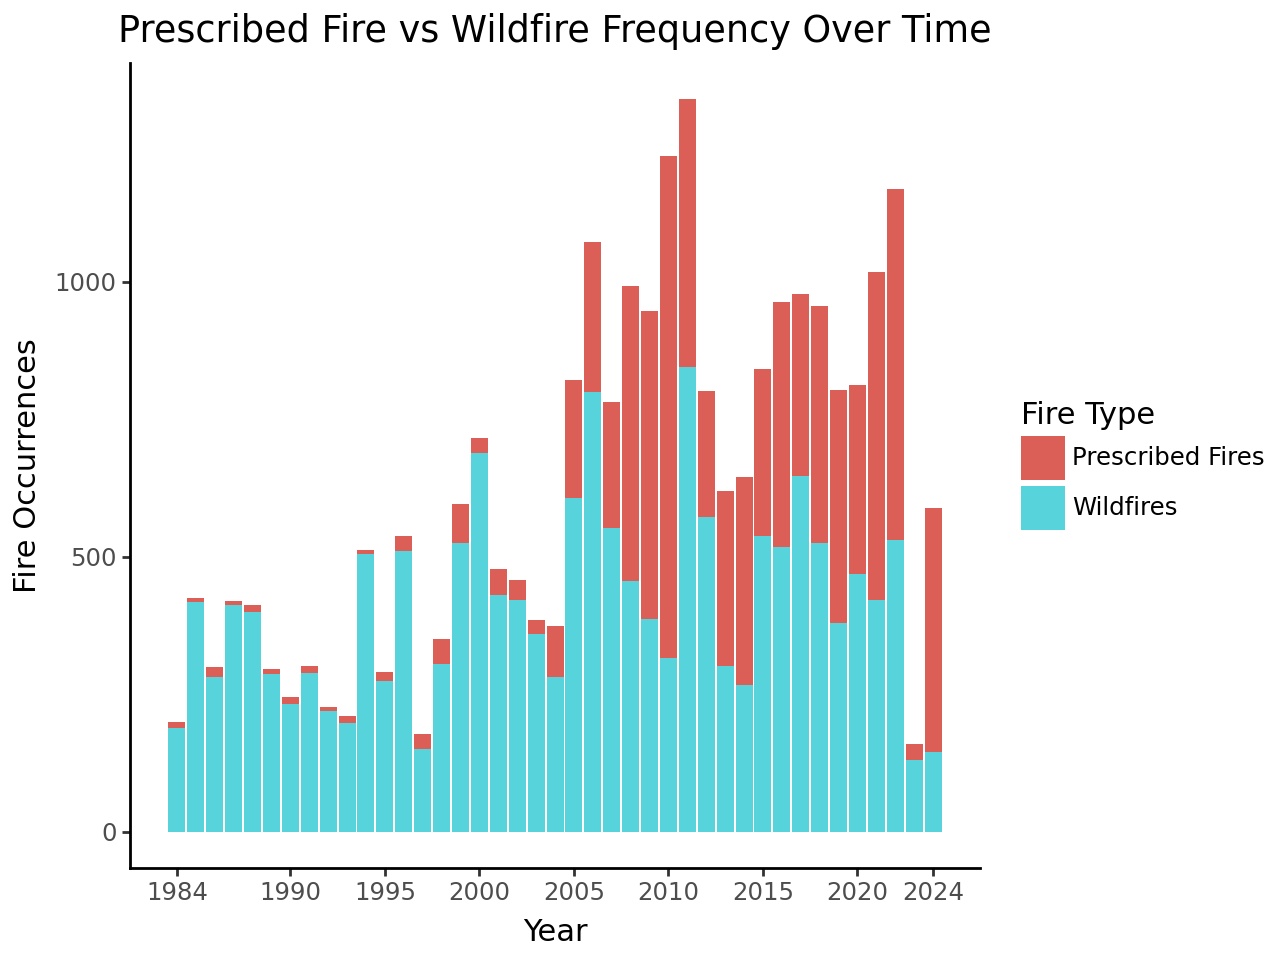

In [86]:
# graph stacked bar chart of prescribed vs wildfires over time
(
    ggplot(df_freq_melted, aes(x = 'Year', y = 'value', fill = 'series'))
    + geom_bar(stat = 'identity')
    + xlab("Year")
    + ylab("Fire Occurrences")
    + labs(fill = 'Fire Type')
    + ggtitle("Prescribed Fire vs Wildfire Frequency Over Time")
    + scale_x_continuous(breaks = [1984, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024])
    + theme_classic()
)


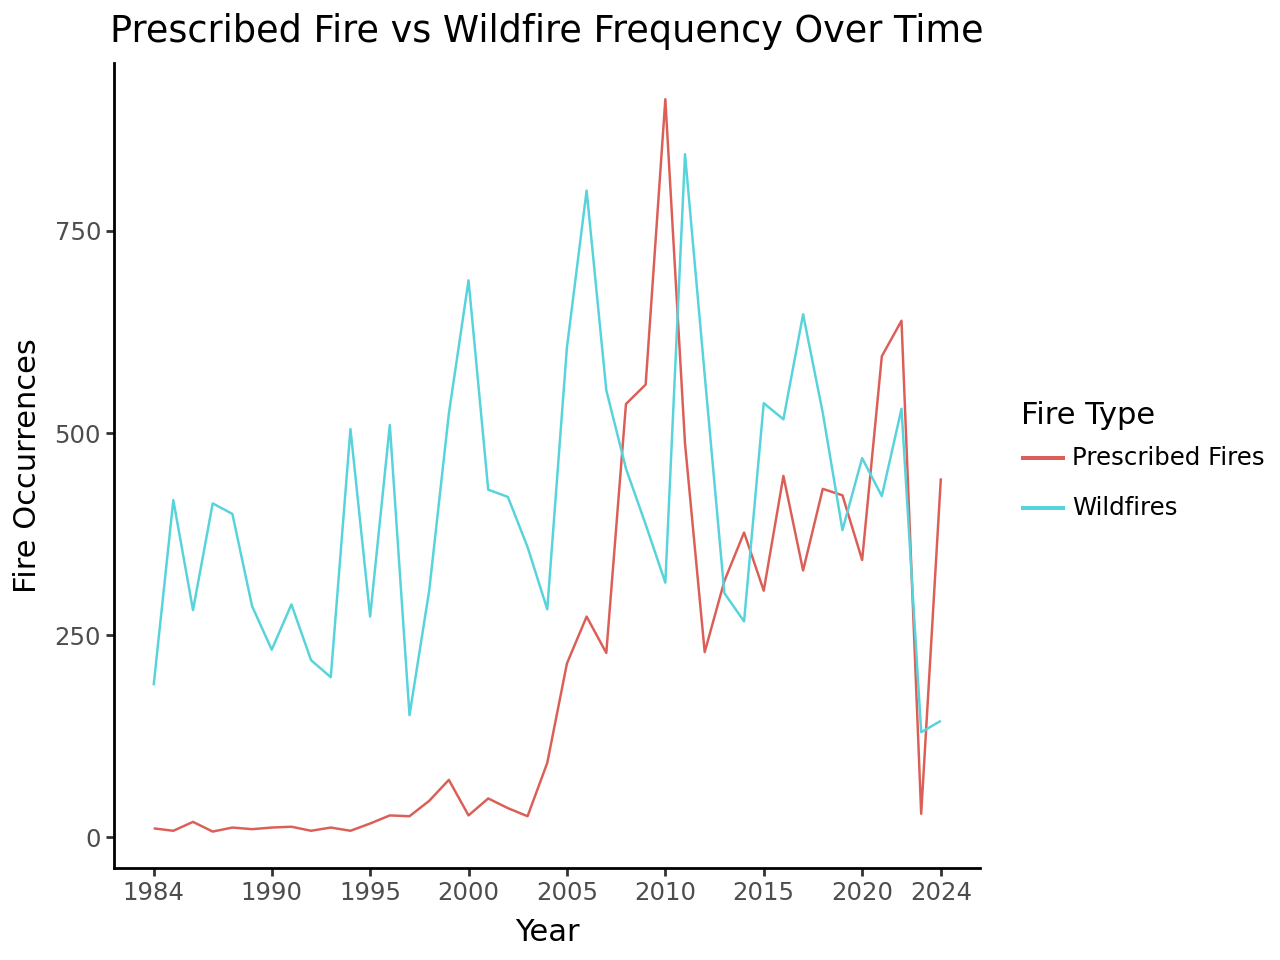

In [89]:
# line graph of prescribed vs wildfire frequency over time
(
    ggplot(df_freq_melted, aes(x = 'Year', y = 'value', color = 'series'))
    + geom_line()
    + xlab("Year")
    + ylab("Fire Occurrences")
    + labs(color = 'Fire Type')
    + ggtitle("Prescribed Fire vs Wildfire Frequency Over Time")
    + scale_x_continuous(breaks = [1984, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024])
    + theme_classic()
)

In [28]:
# prescribed fires burn area
df_prescribed_acres = df_prescribed.pivot_table(index = 'Year', values = 'BurnBndAc', aggfunc = 'sum')
df_prescribed_acres['BurnBndAc'] = df_prescribed_acres['BurnBndAc'] / 1000000
df_prescribed_acres = df_prescribed_acres.reset_index()
df_prescribed_acres.head()

,Year,BurnBndAc
0,1984,0.020773
1,1985,0.024421
2,1986,0.031982
3,1987,0.010226
4,1988,0.016283


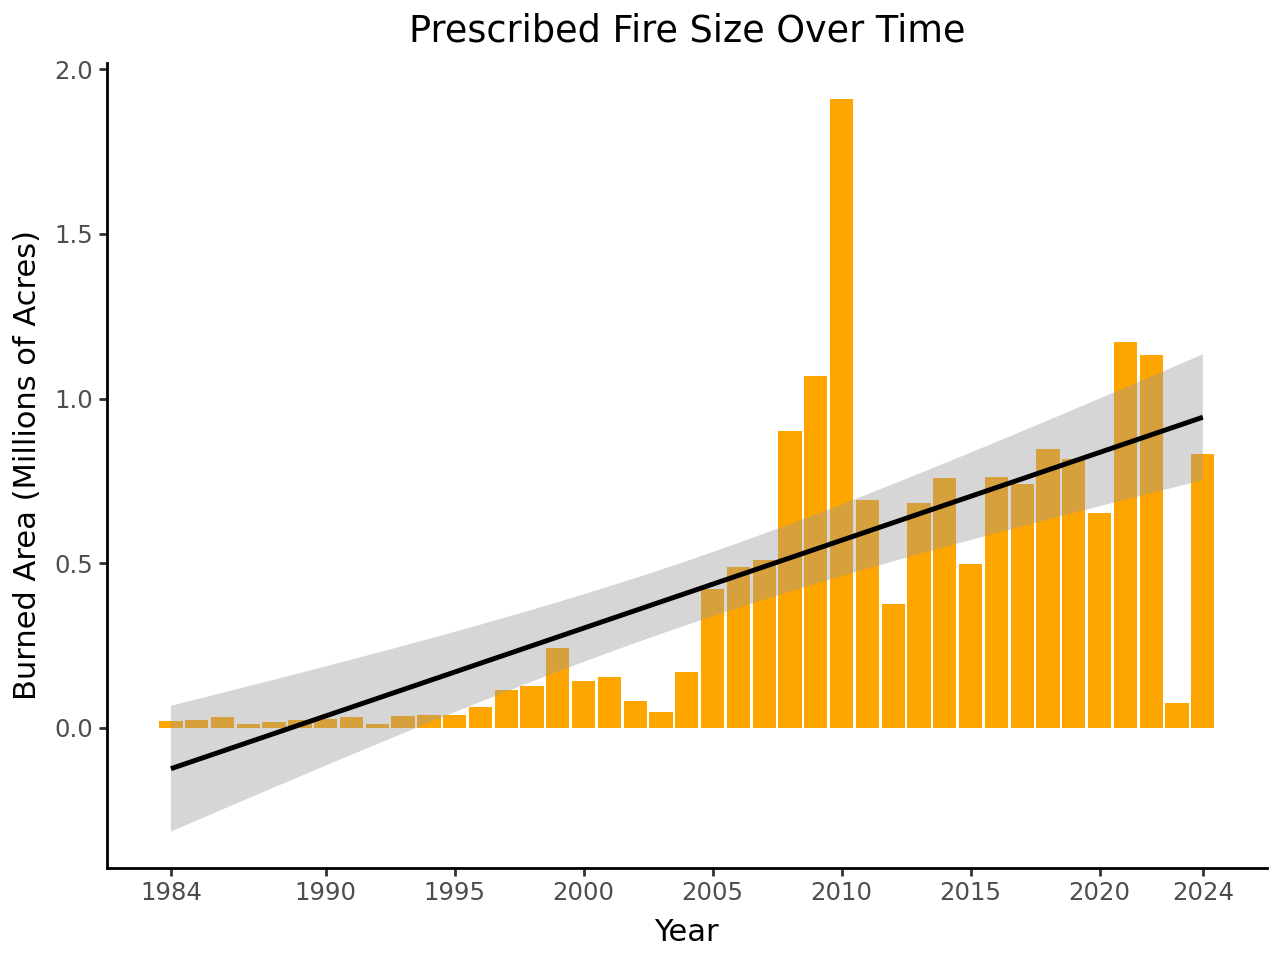

In [75]:
# prescribed fires acres burned over time
(
    ggplot(df_prescribed_acres, aes(x = 'Year', y='BurnBndAc'))
    + geom_bar(stat = 'identity', fill = 'orange')
    + geom_smooth(method='lm')
    + xlab("Year")
    + ylab("Burned Area (Millions of Acres)")
    + ggtitle("Prescribed Fire Size Over Time")
    + scale_x_continuous(breaks = [1984, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024])
    + scale_y_continuous()
    + theme_classic()
)

In [78]:
# merge acres
df_acres_merged = pd.merge(df_wildfires_acres, df_prescribed_acres, on = 'Year')
df_acres_merged = df_acres_merged.rename(columns = {'BurnBndAc_x': 'Wildfires', 'BurnBndAc_y': 'Prescribed Fires'})
df_acres_merged.head()

,Year,Wildfires,Prescribed Fires
0,1984,1.239015,0.020773
1,1985,3.198033,0.024421
2,1986,1.824537,0.031982
3,1987,2.290434,0.010226
4,1988,4.627236,0.016283


In [80]:
# melt acres
df_acres_melted = pd.melt(df_acres_merged, id_vars=['Year'], value_vars=['Wildfires', 'Prescribed Fires'], var_name='series', value_name='value')
df_acres_melted.head()

,Year,series,value
0,1984,Wildfires,1.239015
1,1985,Wildfires,3.198033
2,1986,Wildfires,1.824537
3,1987,Wildfires,2.290434
4,1988,Wildfires,4.627236


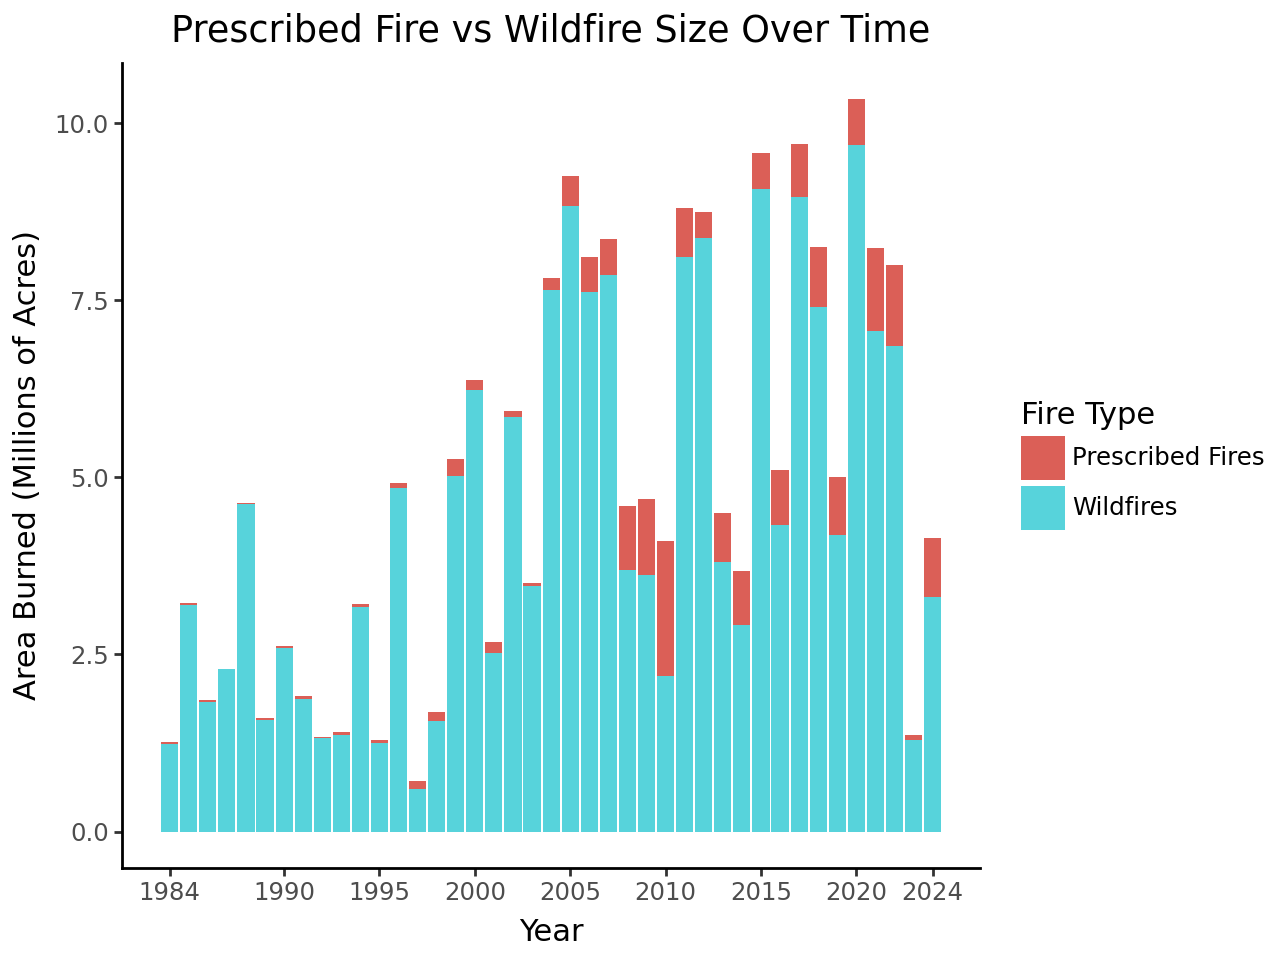

In [82]:
# prescribed acres burned vs wildfire acres burned over time
(
    ggplot(df_acres_melted, aes(x = 'Year', y = 'value', fill = 'series'))
    + geom_bar(stat = 'identity')
    + xlab("Year")
    + ylab("Area Burned (Millions of Acres)")
    + labs(fill = 'Fire Type')
    + ggtitle("Prescribed Fire vs Wildfire Size Over Time")
    + scale_x_continuous(breaks = [1984, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024])
    + theme_classic()
)


#Upload State County Polygons

In [31]:
! unzip /content/drive/MyDrive/cb_2018_us_county_500k.zip #unpacks zipped folder

unzip:  cannot find or open /content/drive/MyDrive/cb_2018_us_county_500k.zip, /content/drive/MyDrive/cb_2018_us_county_500k.zip.zip or /content/drive/MyDrive/cb_2018_us_county_500k.zip.ZIP.


In [32]:
shp = "cb_2018_us_county_500k.shp"
df_counties = gpd.read_file(shp) #reads in shape file
df_counties.head()

DataSourceError: cb_2018_us_county_500k.shp: No such file or directory

In [ ]:
#plot spatial data

(ggplot()
  + geom_map(df_counties, aes(geometry = 'geometry', fill='STATEFP'), show_legend = False)
  + labs(fill='STATEFP')
  + xlim(-5e6,3e6)
  + ylim(-2.5e6, 4e6)
  + theme_classic()
  + theme(axis_line=element_line(color="white"),
          axis_ticks=element_line(color = "white"),
          axis_text=element_line(color='white'),
          text=element_text(size = 12))
  # + xlab("")
  # + ylab("")
 )

#Initial Zoom in on State Data

In [ ]:
CA_df = df[df['State'] == 'CA']

CA_df.head()

In [ ]:
CA_df["dNBR_offst"].max()

In [ ]:
#plot spatial data

(ggplot()
  + geom_map(CA_df, aes(geometry = 'geometry', fill = 'dNBR_offst'), color = 'grey')
  + scale_fill_gradientn(colors = ["#beedcd", "#ed550e"],limits = [0, 200])
  + labs(fill='dNBR_offst')
  + theme_classic()
  + theme(axis_line=element_line(color="white"),
          axis_ticks=element_line(color = "white"),
          axis_text=element_line(color='white'),
          text=element_text(size = 12))
  # + xlab("")
  # + ylab("")
 )

In [ ]:
#plot spatial data

(ggplot()
  + geom_map(df, aes(geometry = 'geometry', fill='High_T'))
  + labs(fill='High_T')
  + theme_classic()
  + theme(axis_line=element_line(color="white"),
          axis_ticks=element_line(color = "white"),
          axis_text=element_line(color='white'),
          text=element_text(size = 12))
  # + xlab("")
  # + ylab("")
 )